Try to find if trajectories feature can be used to support early stopping

In [1]:
import os, sys
import json
import torch
import numpy as np


sys.path.append("..")
from singleVis.data import NormalDataProvider
from singleVis.eval.evaluator import Evaluator
from singleVis.projector import DVIProjector
from singleVis.vis_models import vis_models as vmodels

2023-09-27 22:41:13.505491: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 22:41:13.540351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 22:41:14.245109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
VIS_METHOD = "tDVI" # DeepVisualInsight
CONTENT_PATH = "/home/xianglin/data/noise/symmetric/resnet18_mnist/10"
GPU_ID = "1"

In [3]:
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

In [4]:
SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]
EPOCH_NAME = config["EPOCH_NAME"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
VIS_MODEL = VISUALIZATION_PARAMETER['VIS_MODEL']
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

In [5]:
import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

In [6]:
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, classes=CLASSES, epoch_name=EPOCH_NAME, verbose=1)

Finish initialization...


In [7]:
VIS_MODEL_NAME = "tDVI_cnAE_estimation-sampling"
VIS_MODEL = "cnAE"
model = vmodels[VIS_MODEL](ENCODER_DIMS, DECODER_DIMS)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, epoch_name=EPOCH_NAME, device=DEVICE)
evaluator = Evaluator(data_provider,projector, metric="euclidean")

In [8]:
import json
with open(f"{CONTENT_PATH}/noisy_label.json", "r") as f: 
    noise_labels = np.array(json.load(f))
with open(f"{CONTENT_PATH}/clean_label.json", "r") as f: 
    clean_labels = np.array(json.load(f))

idxs = np.argwhere(noise_labels!=clean_labels).squeeze()

In [9]:
# with open(f"{CONTENT_PATH}/corrupted_idxs.json", "r") as f: 
#     idxs = np.array(json.load(f))

In [10]:
# idxs = np.array([])

In [11]:
# ground truth
mnist_consistency_score = np.load("/home/xianglin/git_space/structural-regularity/mnist-cscores.npy", allow_pickle=True)

In [15]:
END = 4

In [16]:
from singleVis.training_dynamics import TD
td = TD(data_provider, projector, (1,END,1))

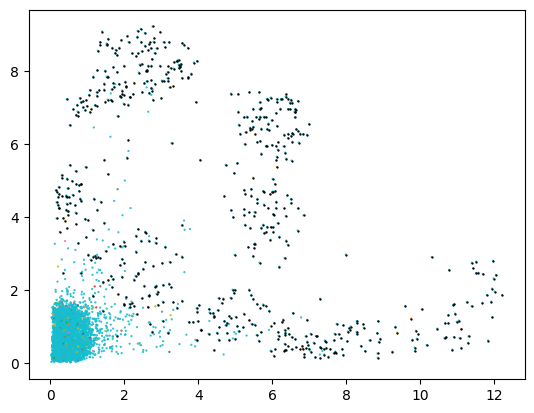

In [17]:
positions = td.position_dynamics()
td.show_ground_truth(positions,END, idxs, 5, method="RoG", colors=mnist_consistency_score)

In [24]:
positions = td.position_high_dynamics()
trajectories = positions.reshape(len(positions), END, -1)
# Radius of Gyration
mean_t = trajectories.mean(axis=0)
embeddings = np.abs(trajectories-mean_t).mean(axis=1)

In [25]:
embeddings = td.simplify(embeddings, END, method="UMAP")

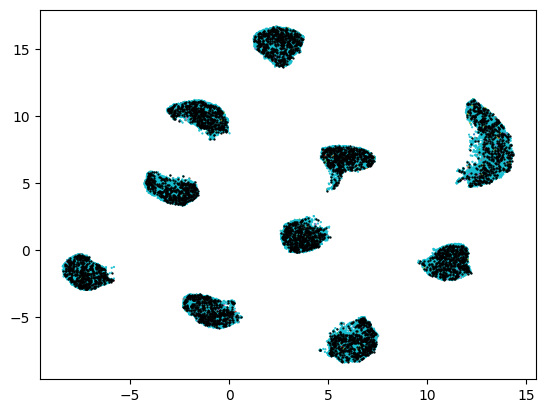

In [26]:
td.plot_ground_truth(embeddings, idxs, colors=mnist_consistency_score)